# Preview
This notebook is an academic mini-project  to apply aquired knowledge in  Big data course  with the suitable tools.
## About the Dataset 📖
1 million row of air quality data in Germany provided on request 
> Data mesuring date  : january 2019
## Goal 🛬
Implement Getis-Ord Gi* statistic to detect cold and hot spots using Apache Spark for air quality analytics in Germany

## Business understanding 
### ***Spatial autocorrelation***
Is whether points (in our case molecules in the air) that are close together are related to each other (i.e., are not spatially independent) as compared to those points farther apart. Spatial autocorrelation can be defined globally as well as locally based on the level of the spatial analysis units.
### ***Getis-Ord Gi**** ***statistic***

The Local Getis-Ord G* statistic calculate the Z-score which is used to determine where individuals with high or low values cluster spatially.

### ***PM2.5 and PM10***

In our Dataset PM2.5 and PM10 are reffered to respectively P2 and P1 (µg/m³) 


*   PM 2.5 refers to a category of particulate pollutant that is 2.5 microns or smaller in size.
*   PM 10 refers to a category of particulate pollutant that is 10 microns or bigger in size.


average PM2.5 (24h) | average PM10 (24h) | AQI category
--- | --- | ---
0 - 15.4 | 0 - 54 | Good
15.5 - 40.4  | 55 - 154 | Moderate
40.5 - 65.4 | 155 - 254 | USG 
65.5 - 150.4 | 255 -354  | Unhealthy 
150.5 - 250.4 | 355 - 424 | Very Unhealthy
250.5 - 500.4 | 425 - 604 | Hazardous


## Summary 🛫


1.   Setup
2.   Exploratory Data analysis
3.   Computing Spatial autocorrelation
4.   Visualizing hot and cold spots



---


Author © : [Med Fourat Ben Salah](mailto:mohamedfouratb@gmail.com)


# Setup

In [ ]:
!pip install pyspark -q
!pip install pysal -qqq

In [ ]:
import pyspark
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import (stddev, mean, col, countDistinct,
                                     isnan, when, count, isnull, split,
                                    concat, dayofweek, struct)
from pyspark.sql.types import IntegerType, FloatType, TimestampType, StructType
import plotly
import plotly.graph_objects as go
import plotly.express as px
import libpysal
from esda.getisord import G_Local
import numpy as np
import geopandas as gpd

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.



In [ ]:
spark = SparkSession.builder.master("local[*]") .appName('Spatial_autocorrelation') .getOrCreate()

# Exploratory data analysis

In [ ]:
data = spark.read.option('header',True).csv('/content/drive/MyDrive/million.csv',sep=';')
print(type(data))
data.printSchema()

<class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- sensor_id: string (nullable = true)
 |-- sensor_type: string (nullable = true)
 |-- location: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lon: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- P1: string (nullable = true)
 |-- durP1: string (nullable = true)
 |-- ratioP1: string (nullable = true)
 |-- P2: string (nullable = true)
 |-- durP2: string (nullable = true)
 |-- ratioP2: string (nullable = true)



In [ ]:
data.count()

1000000

In [ ]:
#first 3 rows
data.limit(3).toPandas()

sensor_id sensor_type location     lat  ... ratioP1     P2 durP2 ratioP2
0     11737      SDS011     5926  49.014  ...    None   2.20  None    None
1     18762      SDS011     9510  49.846  ...    None  27.63  None    None
2      6890      SDS011     3484  48.714  ...    None  49.30  None    None

[3 rows x 12 columns]

##Type casting

In [ ]:
data = data.withColumn('sensor_id', data['sensor_id'].cast(IntegerType()))
data = data.withColumn('location', data['location'].cast(IntegerType()))
data = data.withColumn('P1', data['P1'].cast(FloatType()))
data = data.withColumn('P2', data['P2'].cast(FloatType()))
data = data.withColumn('lat', data['lat'].cast(FloatType()))
data = data.withColumn('lon', data['lon'].cast(FloatType()))
data = data.withColumn('timestamp', data['timestamp'].cast(TimestampType()))

## Exploring columns

### sensor id and sensor type

In [ ]:
sensor_id=data.select(countDistinct('sensor_id'))
sensor_t=data.select(countDistinct('sensor_type'))
sensor_id.show()
sensor_t.show()

+-------------------------+
|count(DISTINCT sensor_id)|
+-------------------------+
|                     7245|
+-------------------------+

+---------------------------+
|count(DISTINCT sensor_type)|
+---------------------------+
|                          1|
+---------------------------+



all sensors have the same type < SDS011 > -> drop the sensor_type  column

In [ ]:
data = data.drop(*['sensor_type'])
data.printSchema()

root
 |-- sensor_id: integer (nullable = true)
 |-- location: integer (nullable = true)
 |-- lat: float (nullable = true)
 |-- lon: float (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- P1: float (nullable = true)
 |-- durP1: string (nullable = true)
 |-- ratioP1: string (nullable = true)
 |-- P2: float (nullable = true)
 |-- durP2: string (nullable = true)
 |-- ratioP2: string (nullable = true)



### P1, P2 dur and ratio

In [ ]:
data.select([count(when(isnull(c), c)).alias(c) for c in data.columns]).show()

+---------+--------+---+---+---------+---+-------+-------+---+-------+-------+
|sensor_id|location|lat|lon|timestamp| P1|  durP1|ratioP1| P2|  durP2|ratioP2|
+---------+--------+---+---+---------+---+-------+-------+---+-------+-------+
|        0|       0|  0|  0|        0|  1|1000000|1000000|  1|1000000|1000000|
+---------+--------+---+---+---------+---+-------+-------+---+-------+-------+



all the cells in durP1, ratioP1, durP2, ratioP2 are none -> drop them

In [ ]:
data = data.drop(*['durP1','ratioP1','durP2','ratioP2'])
data = data.dropna()
data.printSchema()

root
 |-- sensor_id: integer (nullable = true)
 |-- location: integer (nullable = true)
 |-- lat: float (nullable = true)
 |-- lon: float (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- P1: float (nullable = true)
 |-- P2: float (nullable = true)



### timestamp

Since the data we have is for january 2019  we can only keep the DD - HH:MM:SS


1.   Split date and time
2.   Drop year and month from day
3.   Add weekday column (it will help since the emission of gases is different in weekends)



In [ ]:
splited_timestamp = split(data['timestamp'], ' ')
data = data.withColumn('date', splited_timestamp.getItem(0))
data = data.withColumn('time', splited_timestamp.getItem(1))
splited_timestamp = split(data['date'], '-')
data = data.withColumn('day', splited_timestamp.getItem(2))

data.limit(3).toPandas()

sensor_id  location        lat     lon  ...         P2        date      time day
0      11737      5926  49.014000  12.043  ...   2.200000  2019-01-15  07:12:34  15
1      18762      9510  49.846001  19.718  ...  27.629999  2019-01-16  15:39:23  16
2       6890      3484  48.714001   9.200  ...  49.299999  2019-01-21  22:10:21  21

[3 rows x 10 columns]

In [ ]:
dow = dayofweek(data['date'])
data = data.withColumn('dayofweek',dow)

data = data.drop(*['date'])

data = data.withColumn('day', data['day'].cast(IntegerType()))

data.printSchema()
data.limit(3).toPandas()

root
 |-- sensor_id: integer (nullable = true)
 |-- location: integer (nullable = true)
 |-- lat: float (nullable = true)
 |-- lon: float (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- P1: float (nullable = true)
 |-- P2: float (nullable = true)
 |-- time: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)



sensor_id  location        lat     lon  ...         P2      time  day dayofweek
0      11737      5926  49.014000  12.043  ...   2.200000  07:12:34   15         3
1      18762      9510  49.846001  19.718  ...  27.629999  15:39:23   16         4
2       6890      3484  48.714001   9.200  ...  49.299999  22:10:21   21         2

[3 rows x 10 columns]

### location

In [ ]:
location=data.select(countDistinct('location'))
sensor_id.show()
location.show()
corr = data.stat.corr('location', 'sensor_id')
print('correlation between location and sensor_id :',corr)


+-------------------------+
|count(DISTINCT sensor_id)|
+-------------------------+
|                     7245|
+-------------------------+

+------------------------+
|count(DISTINCT location)|
+------------------------+
|                    7248|
+------------------------+

correlation between location and sensor_id : 0.9769143408066291


as sensor_id contains 97% of the location information we can  drop the location column


In [ ]:
data = data.drop(*['location'])
data.printSchema()

root
 |-- sensor_id: integer (nullable = true)
 |-- lat: float (nullable = true)
 |-- lon: float (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- P1: float (nullable = true)
 |-- P2: float (nullable = true)
 |-- time: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)



Now we have all the features columns we need we can visualize the data to better understand it

## Data visualisation

One day of data plotting on the map

In [ ]:
first_day_data = data.filter(data['day']==1)

In [ ]:
fig = px.scatter_mapbox(first_day_data.toPandas(), lat='lat', lon='lon', hover_name='sensor_id', hover_data=['P1','P2'],
                        color_discrete_sequence=['fuchsia'], zoom=4, height=400)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

exemple of evolution of P1 and P2 in 24h (wednesday) detected by the sensor with id=19074 located at Frankfurt

In [ ]:
tus_data = data.filter(data['day']==1)
one_sensor24h = tus_data.filter(tus_data['sensor_id']==19074).toPandas()
fig = go.Figure([
    go.Scatter(
        name='PM10',
        x=one_sensor24h['timestamp'],
        y=one_sensor24h['P1'],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    ),
   go.Scatter(
        name='PM2.5',
        x=one_sensor24h['timestamp'],
        y=one_sensor24h['P2'],
        mode='lines',
        line=dict(color='#444'),
    ),
])
fig.update_layout(
    yaxis_title='indices',
    title='Evolution of PM2.5 and PM10 in 24H',
    hovermode="x"
)
fig.show()

exemple of evolution of P1 and P2 in 24h (30st jan) detected by the sensor with id=19074 located at Frankfurt

In [ ]:
sun_data = data.filter(data['day']==27)
one_sensor24h = sun_data.filter(sun_data['sensor_id']==19074).toPandas()
fig = go.Figure([
    go.Scatter(
        name='PM10',
        x=one_sensor24h['timestamp'],
        y=one_sensor24h['P1'],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    ),
   go.Scatter(
        name='PM2.5',
        x=one_sensor24h['timestamp'],
        y=one_sensor24h['P2'],
        mode='lines',
        line=dict(color='#444'),
    ),
])
fig.update_layout(
    yaxis_title='indices',
    title='Evolution of PM2.5 and PM10 in 24H',
    hovermode="x"
)
fig.show()

Lower P1 and P2 rate on weekends

In [ ]:
data.stat.corr('P1', 'P2')

0.9362910888884655

P1 and P2 are highly correlated

# Computing Spatial autocorrelation with Getis-Ord Gi* statistic

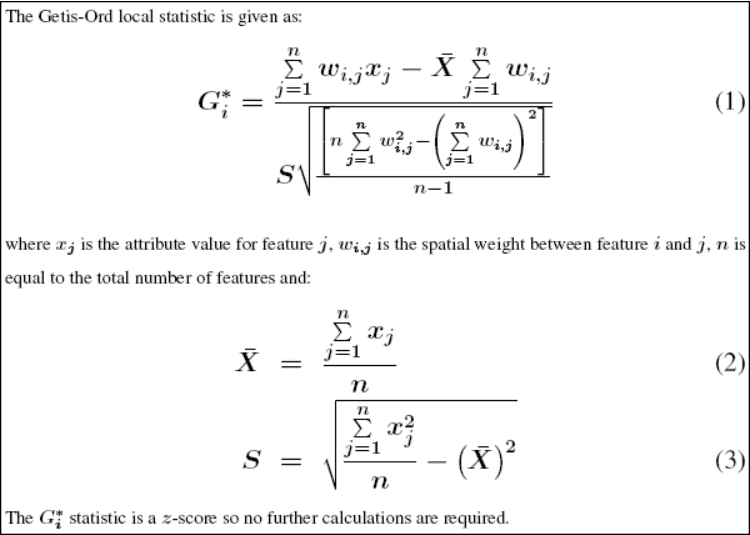


1.   Filter the sensors located in germany and neighbors: 47.561<= lat <= 54.831, 6 <= lon <= 14.669
2.   Filter the data = 1st january
3.   Filter range(1hour)
4.   Create GeoPandas dataframe with geometry column (point)
5.   Compute the weights using KNN
6.   Compute the Z score using G* l

---





In [ ]:
dayOneData = data.filter(data['day']==1)
GermanyData = dayOneData.where((47.561 <= col('lat')) & (col('lat') <= 54.831) )
GermanyData = GermanyData.where((6 <= col('lon')) & (col('lon') <= 14.669) )

In [ ]:
fig = px.scatter_mapbox(GermanyData.toPandas(), lat='lat', lon='lon', hover_name='sensor_id', hover_data=['P1','P2'],
                        color_discrete_sequence=['fuchsia'], zoom=4, height=400)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
GermanyData = GermanyData.filter(col('time').between('09:00:00','10:00:00'))
print(GermanyData.count())
GermanyData.limit(3).toPandas()

926


sensor_id        lat    lon  ...      time  day  dayofweek
0       3217  49.702000  8.618  ...  09:56:58    1          3
1      11893  49.695000  8.662  ...  09:07:39    1          3
2        729  48.977001  8.452  ...  09:24:36    1          3

[3 rows x 9 columns]

In [ ]:
df = GermanyData.toPandas()
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.head()

sensor_id        lat     lon  ... day  dayofweek                   geometry
0       3217  49.702000   8.618  ...   1          3   POINT (8.61800 49.70200)
1      11893  49.695000   8.662  ...   1          3   POINT (8.66200 49.69500)
2        729  48.977001   8.452  ...   1          3   POINT (8.45200 48.97700)
3      15478  48.525002  12.145  ...   1          3  POINT (12.14500 48.52500)
4       4039  51.563999   6.999  ...   1          3   POINT (6.99900 51.56400)

[5 rows x 10 columns]

In [ ]:
weights = libpysal.weights.KNN.from_dataframe(gdf,geom_col='geometry',k=10)
weights.transform = 'R'

/usr/local/lib/python3.7/dist-packages/libpysal/weights/util.py:1073: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



We will compute the Z score according to the P1 values (same for P2 because its approximetly a biased function from P1)

In [ ]:
y = gdf['P1'].to_numpy().astype(float)
g = G_Local(y, weights, star=True)

/usr/local/lib/python3.7/dist-packages/esda/getisord.py:591: UserWarning:

Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.



In [ ]:
gdf['z_score'] = g.z_sim
gdf['p_score'] = g.p_sim
gdf.head(3)

sensor_id        lat    lon  ...                  geometry   z_score  p_score
0       3217  49.702000  8.618  ...  POINT (8.61800 49.70200) -0.577546    0.002
1      11893  49.695000  8.662  ...  POINT (8.66200 49.69500) -0.573222    0.002
2        729  48.977001  8.452  ...  POINT (8.45200 48.97700) -0.466696    0.126

[3 rows x 12 columns]

# visualizing hot and cold spots

significant clusters are clusters with p value < 0.05<br>
A significant cluster can be :<br>


> Hot -> z_score > 0


> Cold -> z_score <= 0




In [ ]:
def spot_type(Ps, Zs):
   result=[None]*len(Ps)
   for idx in range(len(Ps)):
     if Ps[idx] > 0.05:
       result[idx] = 'non-sig' #non-significant
     else:
        if Zs[idx] > 0:
          result[idx] = 'hot' #hot
        else :
          result[idx] = 'cold' #cold
   return result

gdf['spot_type'] = spot_type(gdf['p_score'],gdf['z_score'])
gdf.head(3)

sensor_id        lat    lon  ...   z_score  p_score  spot_type
0       3217  49.702000  8.618  ... -0.577546    0.002       cold
1      11893  49.695000  8.662  ... -0.573222    0.002       cold
2        729  48.977001  8.452  ... -0.466696    0.126    non-sig

[3 rows x 13 columns]

In [ ]:
fig = px.scatter_mapbox(gdf, lat="lat", lon="lon", color="spot_type",  mapbox_style="open-street-map", zoom=4,color_discrete_map={
                "non-sig": "rgb(179,179,179)",
                "hot": "red",
                "cold": "blue"})
fig.show()